<a href="https://colab.research.google.com/github/vamsikrishna00466/Machine-learning/blob/main/Back_order_prediction_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## importing libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
print('importing libraries completed')

importing libraries completed


In [2]:
"""
Before going to the data anlysis we are creating two functions for detecting missing data
"""
## Function for detect missing data columns w.r.t rows
def missing_columns_detection(df):
  ## misssing values columns in descending order
  nan = df.isnull().sum()
  nan=nan.sort_values(ascending=False)
  print('####################\n    Missing data columns with frequency of missing rows \n####################\n',
        nan[nan>0])
  return

## Function for detecting missing data rows only
def missing_value_rows_detection(train_df):
  train_missing_data= len((train_df[pd.isnull(train_df).any(axis=1)]))
  if train_missing_data==0:
    print('This data have no missing values')
  elif train_missing_data!=0:
    print('Number of missing values(Rows):',train_missing_data)


In [3]:
"""
now we are importing the data from our google drive, our data was is csv formate, so we are using here pandas.read_csv
 for importing data.
 we have two files, one is trian data set and other one is test data set.
 we are taking two variables train_df, test_df for saving our train and test data for our analysis
"""
## extracting Data
train_df= pd.read_csv('/content/drive/MyDrive/SCA Projects/Back Order Prediction/Data/Kaggle_Training_Dataset_v2.csv')
test_df = pd.read_csv('/content/drive/MyDrive/SCA Projects/Back Order Prediction/Data/Kaggle_Test_Dataset_v2.csv')
print('Data Extraction completed..')

## comining train and test dataframe
df = train_df[:-1].append(test_df[:-1])
df=df.reset_index()
del df['index']## droping index column
del train_df##deleting train data
del test_df##deleting test data

## filling missing values by median
def Impute_nan(data,feature,median):
    data[feature] = df[feature].fillna(median)
##filling missing values in leadTime by median
median_lead_time = df["lead_time"].median()
Impute_nan(df,"lead_time",median_lead_time)
print('missing values handling completed')

del df['sku']## dropinng sku

## Categorical variables
categorical_column = [column for column in df.columns if df[column].dtype == 'object']
## converting categorical data to numerical data by Binary Encoding
for col in categorical_column:
    df[col] = df[col].map({'No':0, 'Yes':1})

"""
Now we are going to feature scaling step, In this version we are not doing feature selection.
"""

## using mini max scaler to narmalize the data
from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler()

## seperating indipendent and dependent variables
y=df[["went_on_backorder"]]
x = df.drop(columns = ["went_on_backorder"])

# applying minmax scaler data
df1_minmax = pd.DataFrame(min_max.fit_transform(x),columns = x.columns)

## SMOTE using for imbalced data
from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state = 0)
df1_minmax , y1 = oversampler.fit_resample(df1_minmax,y)

## saving oversampled data into new data frames
df1_minmax  = pd.DataFrame(df1_minmax,columns = x.columns)
y1  = pd.DataFrame(y1,columns = y.columns)

print('oversampling, min max scalling completed.')

Data Extraction completed..
missing values handling completed
oversampling, min max scalling completed.


In [4]:
## combining cleaned features and target variables 
df = pd.concat([df1_minmax, y1], axis=1)

In [5]:
df

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0.002205,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.002205,0.173077,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.9999,0.999900,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0.002205,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0000,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0
3,0.002205,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000003,0.0,0.0,0.9910,0.991300,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0.002206,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.247983e-06,0.000006,0.0,0.0,0.0000,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3831903,0.002205,0.153846,0.000000,0.000004,0.000002,0.000002,1.774911e-06,3.000134e-06,2.624196e-06,2.397194e-06,0.000000,0.0,0.0,0.9999,0.999900,0.0,0.0,0.0,0.0,1.0,0.0,1
3831904,0.002205,0.153846,0.000000,0.000010,0.000011,0.000009,5.470994e-06,1.085503e-05,8.493782e-06,8.935762e-06,0.000007,0.0,0.0,0.9993,0.999400,0.0,0.0,0.0,0.0,1.0,0.0,1
3831905,0.002205,0.153846,0.000000,0.000006,0.000095,0.000098,6.729449e-07,4.515449e-07,2.325385e-07,1.557398e-07,0.000032,0.0,0.0,0.9975,0.997501,0.0,1.0,0.0,0.0,0.0,0.0,1
3831906,0.002208,0.153846,0.000119,0.000187,0.000175,0.000187,9.228538e-05,2.025526e-04,1.940921e-04,1.293132e-03,0.000075,0.0,0.0,0.9982,0.999127,0.0,0.0,0.0,0.0,1.0,0.0,1


## feature Selection

1.  domain knowdge
2.  Missing values
3.  Correletion with target variable
4.  Correlation between features
5.  Principal Component Analysis
6.  Forward feature selection
7.  Feature Importance


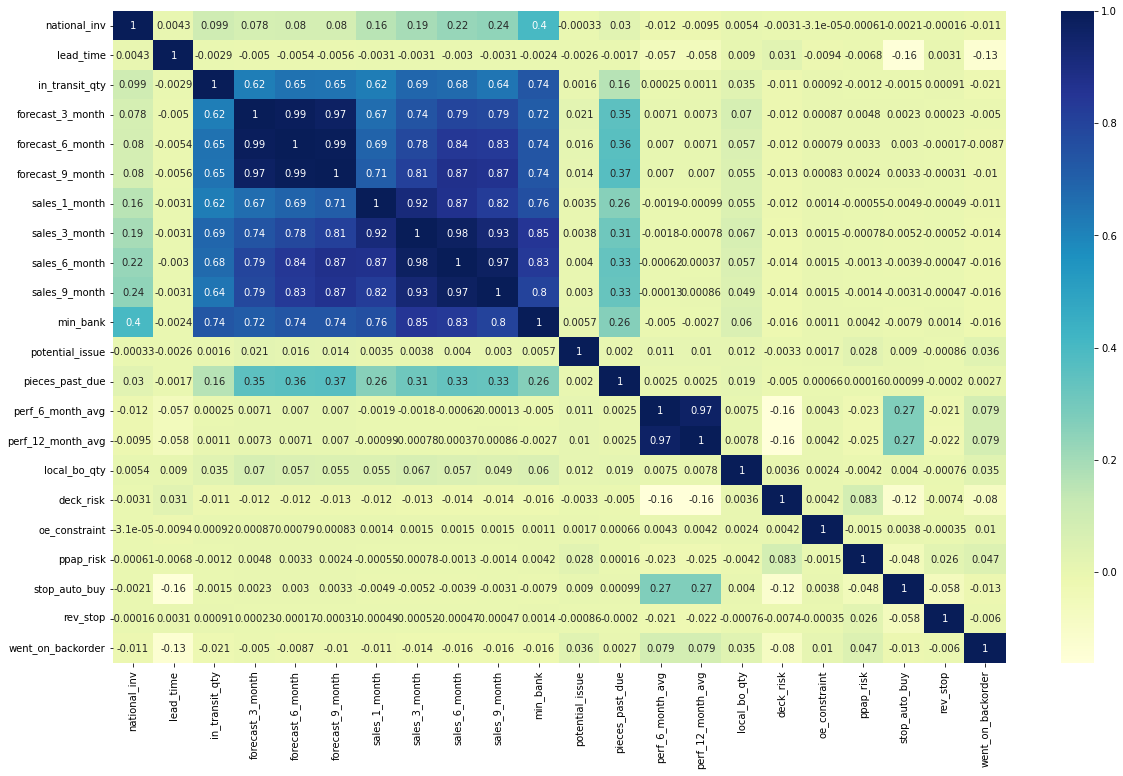

In [6]:
# Check the Correlation

plt.figure(figsize=(20,12))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")
plt.show()

In [7]:
# Checking the Correlation between Independant features

def PearsonCorrelation(data=None, thersold=0.5):
  cor_col = set()
  corr_matrix = data.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i,j]) > thersold:
        cor_col.add(corr_matrix.columns[i])
  return cor_col

In [8]:
PearsonCorrelation(data=df, thersold=0.25)

{'forecast_3_month',
 'forecast_6_month',
 'forecast_9_month',
 'min_bank',
 'perf_12_month_avg',
 'pieces_past_due',
 'sales_1_month',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month',
 'stop_auto_buy'}

I am selecting a correlation thersold is 0.25 above and selecting those above thersold correlation features

In [9]:
# Checking The Information Gain for the features

"""
IG calculates the importance of each feature by measuring the increase in entropy when the feature is given vs. absent.

Algorithm: IG(S, a) = H(S) — H(S | a) Where IG(S, a) is the information for the dataset S for the variable a for a random variable, 
H(S) is the entropy for the dataset before any change (described above) and H(S | a) is the conditional entropy for the dataset in 
the presence of variable a.
"""

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

def FeatureInfoGain(X, y, score, no_need_feat):
  bestfeatures = SelectKBest(score_func=mutual_info_classif, k=no_need_feat) # n is number of features you want to select
  fit = bestfeatures.fit(df1_minmax,y1)
  dfscores = pd.DataFrame(fit.scores_)
  dfcolumns = pd.DataFrame(df1_minmax.columns)
  featureScores = pd.concat([dfcolumns,dfscores],axis=1)
  featureScores.columns = ['Specs','Score']
  return featureScores[featureScores.Score > score]

X = df[[x for x in df.columns.to_list() if x != 'went_on_backorder']]
y = df['went_on_backorder']

FeatureInfoGain(X, y, 0.2, 6)

,Specs,Score
0,national_inv,0.502435
3,forecast_3_month,0.424646
4,forecast_6_month,0.448061
5,forecast_9_month,0.455664
6,sales_1_month,0.369277
7,sales_3_month,0.414894
8,sales_6_month,0.430096
9,sales_9_month,0.437959
10,min_bank,0.226117
19,stop_auto_buy,0.274891


If we use the Tree based Classification Algoritthm we can use this technique to get the bset features based on the score.


In [10]:
''' Seleting the features'''

predictors = ['forecast_6_month', 'forecast_9_month','sales_3_month', 'national_inv','sales_6_month',
              'sales_9_month', 'perf_6_month_avg','perf_12_month_avg', 'forecast_3_month']
target = 'went_on_backorder'

In [11]:
def OutlierRatio(df):
  q1 = df.quantile(0.25)
  q3 = df.quantile(0.75)
  IQR = q3 - q1
  total_outliers = ((df < (q1 - 1.5 * IQR)) | (df > (q3 + 1.5 * IQR))).sum().sort_values(ascending=False)
  total_outl_per = ((total_outliers/ ((df < (q1 - 1.5 * IQR)) | (df > (q3 + 1.5 * IQR))).count()) * 100).sort_values(ascending=False)
  return pd.concat([total_outliers, total_outl_per], axis=1, keys=['Outliers Total', 'Percentage(%)'])

OutlierRatio(df[predictors]).head()

,Outliers Total,Percentage(%)
national_inv,662769,17.296057
forecast_3_month,590377,15.406868
forecast_6_month,586048,15.293895
forecast_9_month,582133,15.191727
sales_6_month,570523,14.888745


We need to scaling the Outlier data .so we can apply the Robust Scalar



In [12]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

X_train,x_test,Y_train,y_test = train_test_split(df[predictors], df[target], test_size=0.3, random_state=7)

transformer = RobustScaler().fit(X_train)
X_train = transformer.transform(X_train)
x_test = transformer.transform(x_test)


In Robust scaling every values is scaled as below.

Values = (value — median)/(75th percentile value — 25th percentile value)

This approach standardizes the data with out considering outliers while scaling the data.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_validate

In [ ]:
## Hyper Parameter Optimization

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10,1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}


## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from xgboost import XGBClassifier

rf=RandomForestClassifier()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=10,cv=2,verbose=2,
                               random_state=100,n_jobs=20)
### fit the randomized model
rf_randomcv.fit(X_train,Y_train)


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


In [ ]:
rf_randomcv.best_estimator_

In [ ]:
rdf_clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=120, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=3, warm_start=False)

rdf_clf.fit(X_train, Y_train)

In [ ]:
y_pred = rdf_clf.predict(x_test)


In [ ]:
# print confusion-matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP){type 1 error} = ', cm[0,1])

print('\nFalse Negatives(FN){type 2 error} = ', cm[1,0])
print('\n\n')

#-------------------------------visualization of confusion matrix -----------------------------------------------------------

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

#----------------------------------classification report ----------------------------------------------------------------------
print('classification report')
print(classification_report(y_test, y_pred))
print('\n\n')
#-----------------------------------classification accuracy -------------------------------------------------------------------
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))
print('\n\n')

#----------------------------------------classification error------------------------------------------------------------------

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))
print('\n\n')

#----------------------------------------precision-----------------------------------------------------------------------------

precision = TP / float(TP + FP)

print('Precision : {0:0.4f}'.format(precision))
print('\n\n')


#--------------------------------------------Recall---------------------------------------------------------------------------
recall = TP / float(TP + FN)

print('Recall or Sensitivity : {0:0.4f}'.format(recall))
print('\n\n')
#--------------------------------------Truepositive rate------------------------------------------------------------------------

true_positive_rate = TP / float(TP + FN)

print('True Positive Rate : {0:0.4f}'.format(true_positive_rate))
print('\n\n')

#--------------------------------------false positive rate---------------------------------------------------------------------
false_positive_rate = FP / float(FP + TN)

print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))
print('\n\n')


In [ ]:
import pickle

#saving the model to the local file system
filename = 'finalized_model.pickle'
pickle.dump(rdf_clf, open(filename, 'wb'))

#saving the scalar to the local file system
filename = 'finalized_scalar.pickle'
pickle.dump(transformer, open(filename, 'wb'))

In [ ]:
newBackordDf[predictors]

loaded_scalar = pickle.load(open('finalized_scalar.pickle', 'rb'))
loaded_model = pickle.load(open('finalized_model.pickle', 'rb'))

In [ ]:
tranfm_features = loaded_scalar.transform([[16.0,32.0,	10.0,	1.0,	23.0,	33.0,	0.83,	0.85,	8.0]])
loaded_model.predict(tranfm_features)
